## Dataset と Dataloader

In [1]:
import torchvision
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from torch import optim, nn
from torch.nn import functional as F
from torch.utils.data import Dataset
from sklearn import datasets
from sklearn.model_selection import train_test_split

### Dataset

In [2]:
# datasetsモジュールに様々なデータセットがある：https://pytorch.org/vision/stable/datasets.html
train_dataset = torchvision.datasets.MNIST('./mnist_data', train=True, download=True)

In [3]:
# 変数にデータが格納されているわけではない
import sys
sys.getsizeof(train_dataset)

48

In [4]:
image, label = train_dataset[0]
print(label)
# そのままでとPIL
image

5


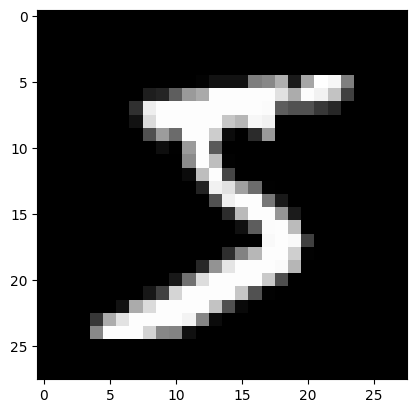

In [5]:
plt.imshow(image, cmap='gray')

In [6]:
len(train_dataset)

60000

### Transform

In [7]:
image

In [8]:
# .ToTensor()
# PIL (もしくはNumpy Array)をTensorに変換する; スケールも0~1になる
image_tensor = transforms.ToTensor()(image)

In [9]:
type(image_tensor)

torch.Tensor

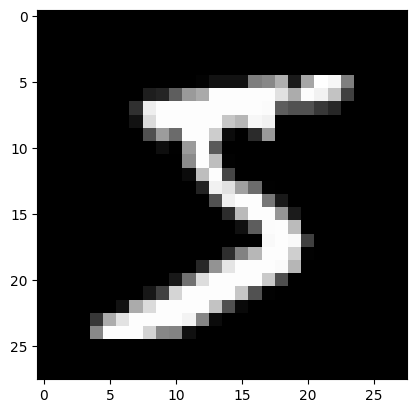

In [10]:
plt.imshow(image_tensor[0], cmap='gray')

In [11]:
# .Normalize()
# # 0.5を引いて0.5で割ることで，0~1を-1~1にする
# -1 ~ 1　にする．平均を0にすることで，学習の効率を上げる
normalized_image_tensor = transforms.Normalize((0.5,), (0.5,))(image_tensor)
print(normalized_image_tensor.min(), normalized_image_tensor.max())

tensor(-1.) tensor(1.)


In [12]:
# Composeを使うことで，複数のTransformを直列にしまとめてくれる．これをDatasetのインスタンス生成時に指定する
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])
transformed_image = transform(image)


In [13]:
transformed_image.shape

torch.Size([1, 28, 28])

In [14]:
# datasetのtransform引数に入れて使用する
train_dataset = torchvision.datasets.MNIST('./mnist_data', train=True, download=True, transform=transform)
val_dataset = torchvision.datasets.MNIST('./mnist_data', train=False, download=True, transform=transform)

In [15]:
image, label = train_dataset[0]
# image

### Dataloader

In [16]:
# DatasetからDataLoaderを作る
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
# validationにはshuffleは不要．だが，可読性やメモリを考えてbatch_sizeは指定する
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=2)

In [17]:
# DataLoaderからデータ取得&描画
images, labels = next(iter(train_loader))
# [batch, ch, h, w]になっている
print(images.shape)
# gridで描画できる
grid_images = torchvision.utils.make_grid(images)
print(grid_images.shape)

torch.Size([32, 1, 28, 28])
torch.Size([3, 122, 242])


tensor([9, 0, 8, 5, 0, 3, 6, 9, 3, 6, 0, 0, 5, 3, 5, 2, 5, 5, 1, 1, 4, 9, 1, 6,
        1, 1, 2, 6, 0, 7, 1, 6])


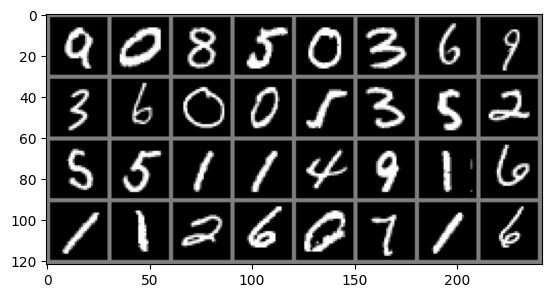

In [18]:
print(labels)
# unnormalize
grid_images = grid_images / 2 + 0.5
plt.imshow(torch.permute(grid_images, (1, 2, 0)))

### DataLoaderを学習ループで使用する

In [19]:
# 入力が[batch, ch, h, w]なので，[batch, chzhxw]にするためにnn.Flatten()を追加
class MLP(nn.Module):
    def __init__(self, num_in, num_hidden, num_out):
        super().__init__()
        self.flatten = nn.Flatten() # [b, c, h, w] -> [b, cxhxw]
        self.l1 = nn.Linear(num_in, num_hidden)
        self.l2 = nn.Linear(num_hidden, num_out)

    def forward(self, x):
        # z1 = self.l1(x)
        # a1 = F.relu(z1)
        # z2 = self.l2(a1)
        x = self.l2(F.relu(self.l1(self.flatten(x))))
        return x

learning_rate = 0.01
model = MLP(28*28, 30, 10)
opt = optim.SGD(model.parameters(), lr=learning_rate)

# ログ
train_losses = []
val_losses = []
val_accuracies = []
for epoch in range(5):
    running_loss = 0.0
    running_val_loss = 0.0
    running_val_acc = 0.0
    
    for train_batch, data in enumerate(train_loader):
        
        X, y = data
        opt.zero_grad()
        # forward
        preds = model(X)
        loss = F.cross_entropy(preds, y)
        running_loss += loss.item()

        # backward
        loss.backward()
        opt.step()

    # validation
    with torch.no_grad():
        for val_batch, data in enumerate(val_loader):
            X_val, y_val = data
            preds_val = model(X_val)
            val_loss = F.cross_entropy(preds_val, y_val)
            running_val_loss += val_loss.item()
            val_accuracy = torch.sum(torch.argmax(preds_val, dim=-1) == y_val) / y_val.shape[0]
            running_val_acc += val_accuracy.item()

    train_losses.append(running_loss/(train_batch + 1))
    val_losses.append(running_val_loss/(val_batch + 1))
    val_accuracies.append(running_val_acc/(val_batch + 1))
    print(f'epoch: {epoch}: train error: {train_losses[-1]}, validation error: {val_losses[-1]}, validation accuracy: {val_accuracies[-1]}')
    

epoch: 0: train error: 0.5990982131520907, validation error: 0.34384458006832735, validation accuracy: 0.9018570287539937
epoch: 1: train error: 0.32972885037064553, validation error: 0.3019029639970761, validation accuracy: 0.9157348242811502
epoch: 2: train error: 0.29297189086079595, validation error: 0.2705959622501232, validation accuracy: 0.922823482428115
epoch: 3: train error: 0.2664662753889958, validation error: 0.25169178879501436, validation accuracy: 0.9239217252396166
epoch: 4: train error: 0.24310794739325842, validation error: 0.22957706379707152, validation accuracy: 0.9309105431309904


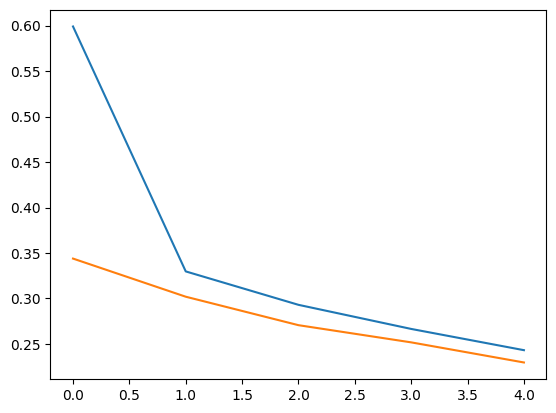

In [20]:
plt.plot(train_losses)
plt.plot(val_losses)

### カスタムのDatasetを作る

In [21]:
class MyDataset(Dataset): # Datasetクラスを継承する
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        X = self.X[idx]
        y = self.y[idx]

        if self.transform:
            X = self.transform(X)

        return X, y

In [22]:
dataset = datasets.load_digits()
target = dataset['target']
images = dataset['images']
# ToTensorを使うため，0~255にする
images = images * (255. / 16.) # 0~16 -> 0~255
images = images.astype(np.uint8)
X_train, X_val, y_train, y_val = train_test_split(images, target, test_size=0.2, random_state=42)

In [23]:
X_train.shape

(1437, 8, 8)

In [24]:
y_train.shape

(1437,)

In [25]:
train_mydataset = MyDataset(X_train, y_train)

In [26]:
# __len__
len(train_mydataset)
# __getitem__
image, label = train_mydataset[0]
print(image.shape)
print(label)

(8, 8)
6


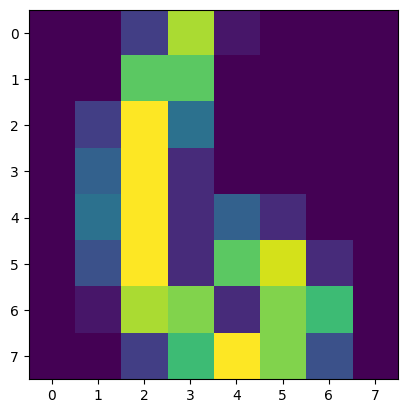

In [27]:
# データ可視化
plt.imshow(image)

In [28]:
# transform
transform = transforms.Compose([
    transforms.ToTensor(),# 0~255 -> 0~1
    transforms.Normalize((.5, ), (.5, )) # 0~1 -> -1~1
])
train_mydataset = MyDataset(X_train, y_train, transform=transform)
val_mydataset = MyDataset(X_val, y_val, transform=transform)
train_myloader = DataLoader(train_mydataset, batch_size=10, shuffle=True, num_workers=2)
val_myloader = DataLoader(val_mydataset, batch_size=10, num_workers=2)
images, labels = next(iter(train_myloader))

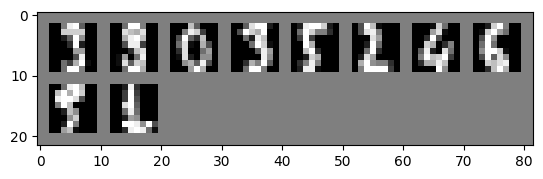

In [29]:
grid_images = torchvision.utils.make_grid(images)
grid_images = grid_images / 2 + 0.5
plt.imshow(torch.permute(grid_images, (1, 2, 0)))